## Weather data analyses
Description of where we got the data from, with link to data
Copy the column names and specifications, etc.

In order to obtain data weather for this project, we decided to use the website MeteoStat, whose link is the following:

https://meteostat.net/pt/place/fr/paris?s=07156&t=2022-10-25/2022-11-01

We decided to download all the recorded data for this function according to the instructions presented in the following link: 

https://dev.meteostat.net/bulk/hourly.html#endpoints

This data comes in a CSV format with the following table of features: 

| Order | Parameter | Description | Type|
| --- | --- | --- | --- |
| 1 | date | The date string(YYYY/MM/DD) | string |
| 2 | hour | The hour(UTC) | Integer |
| 3 | temp | Air temperature in ºC | Float |
| 4 | dwpt | The dew point in ºC | Float |
| 5 | rhum | The relative humidity in percentage | Integer |
| 6 | prcp | The one hour precipitation total in mm | Float |
| 7 | snow | The snow depth in mm | Integer | 
| 8 | wdir | The wind direction in degrees | Categorical(Int) |
| 9 | wspd | The average wind speed in km/h | Float |
| 10 | wpgt | The peak wind gust in km/h | Float | 
| 11 | pres | The sea-level  air pressure in hPa | Float | 
| 12 | tsun | The one hour sunshine total in minutes | Integer |
| 13 | coco | The weather condition code | Categorical(Int) |  





This dataset is open-source and the Meteostat developers have written this message in regard to the utilization of the data: 

"Meteostat data is generally provided under the terms of the Creative Commons Attribution-NonCommercial 4.0 International Public License (CC BY-NC 4.0) (opens new window). You may build upon the material for any purpose, even commercially. However, you are not allowed to redistribute Meteostat data "as-is" for commercial purposes outside of the US.

This is due to the policy of WMO resolution 40 (opens new window). According to the resolution, data must be distributed "free and unrestricted" and "at no more than the cost of reproduction and delivery, without charge for the data and products themselves"."

The licence used by Meteostat can be found in the following link: 
https://creativecommons.org/licenses/by-nc/4.0/#

*Disclaimer: This dataset is the work and property of MeteoStat and the weather Station of Paris-Mounsouris(weather station ID:07156), and we are not endorsed by none of these entities. We give all credits to the dataset creators,and we will use and modify the files in accordance with the MeteoStat license.*  




In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def weather_data_prep() -> pd.DataFrame:
    """
    Loading and preparing weather data for further analysis,
    comprising adding column names, selecting the right time range,
    removing columns with only missing values, and concatenating the date and hour
    to make the time format compatible with the bike_counters data. 

    Parameters: ()
    Returns:
        - weather_data (pd.DataFrame): Data containing weather information for 2020-2021 in Paris    
    """
    # load weather data of Paris from data folder
    weather_data = pd.read_csv("../data/07156.csv")
    weather_data.columns = [
        "date",
        "hour",
        "temp",
        "dwpt",
        "rhum",
        "prcp",
        "snow",
        "wdir",
        "wspd",
        "wpgt",
        "pres",
        "tsun",
        "coco",
    ]

    # select the column range according the train and test parquet
    # we extended the series a bit longer to the end of the year 2021
    weather_data = weather_data[
        (weather_data.date >= "2020-09-01") & (weather_data.date <= "2021-12-31")
    ]

    # remove columns that are only na's
    weather_data.dropna(axis=1, how="all", inplace=True)

    # concat date and hour together to get a variable to merge bike_counters data
    weather_data["date"] = pd.to_datetime(weather_data.date) + pd.to_timedelta(
        weather_data.hour, unit="h"
    )
    
    return weather_data.drop(columns="hour")

In [4]:
weather_data = weather_data_prep()

## Analysing weather data

In [5]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11604 entries, 180135 to 191738
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    11604 non-null  datetime64[ns]
 1   temp    11604 non-null  float64       
 2   dwpt    11604 non-null  float64       
 3   rhum    11604 non-null  float64       
 4   prcp    10505 non-null  float64       
 5   wdir    11604 non-null  float64       
 6   wspd    11604 non-null  float64       
 7   pres    11604 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 815.9 KB


In [6]:
# check NA distribution in the prcp column
weather_data["prcp"].isna().mean()

0.0947087211306446

As we can see above, we did some initial changes to our dataset, namely changing the column names, selecting the date range we are interested in, dropping the columns where all values where *NaN*, and concatenating the date and hour columns in order to have the date in the same formate as the *bike_count*.
After this initial step in preparing our data, we can see that we still have some missing values in the precipitation column (around 10%). In order to tackle this problem and get a better understanding of the data we do some further analysis and potentially imputation to create a whole data set for the bike counters modeling.

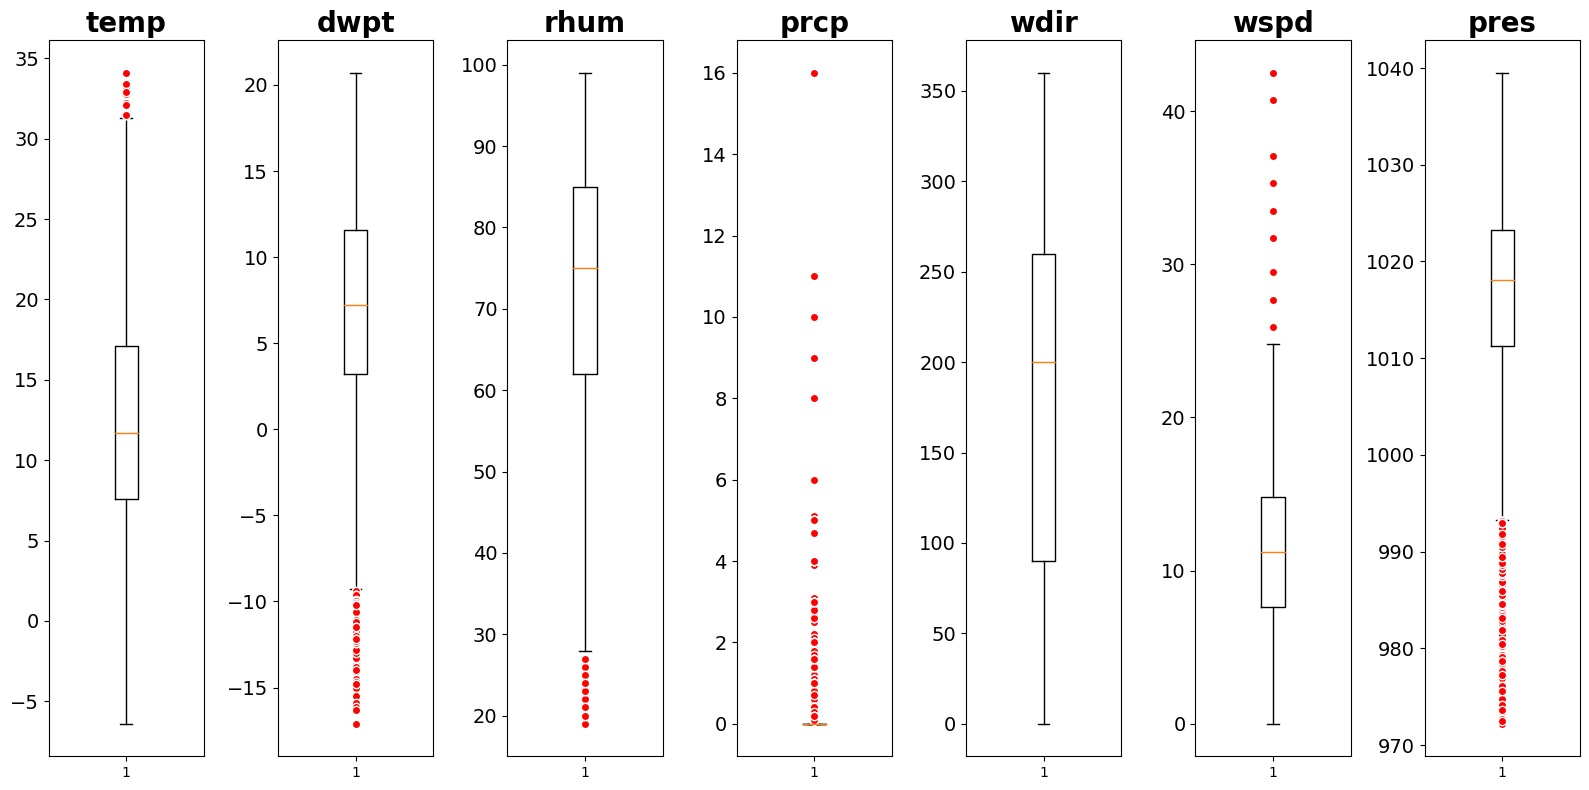

In [7]:
# TODO: remove x-axis values
# creating box plots for every column except dates
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

temp = weather_data.drop(columns="date")
fig, axs = plt.subplots(1, len(temp.columns), figsize=(16,8))

for i, ax in enumerate(axs.flat):
    ax.boxplot(temp.iloc[:,i].dropna(), flierprops=red_circle)
    ax.set_title(temp.columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()

As we can see, for all the boxplots except the wind direction, which is a categorical variable, there are some outliers present. However, we consider these values as natural, since they aren't very far away from the minimum, with the only exception being the values for precipitation, but after a more careful analysis, a value of 16 milimiters per hour does not seem far-fechted, just a very rainy hour and so we have decided, based on these boxplots, that no outlier removal needs to be performed on our dataset.  


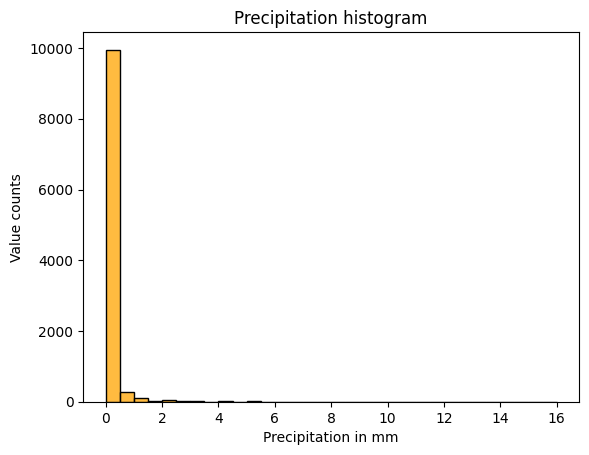

In [8]:
sns.histplot(weather_data['prcp'], binwidth=0.5, color='orange')
plt.xlabel('Precipitation in mm')
plt.ylabel('Value counts')
plt.title('Precipitation histogram')
plt.show()

In [9]:
weather_data['prcp'].describe()

count    10505.000000
mean         0.092832
std          0.459733
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: prcp, dtype: float64

For potential imputation of the percipitation variable, we want to look at the correlation and spearman correlation matrix. We are doing this to understand how the variables are correlated with the precipitation variable  and also to check if there are other correlations between the different features, which could jeopardise the use of a regression model. 

In [10]:
corr = temp.corr()
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,temp,dwpt,rhum,prcp,wdir,wspd,pres
temp,1.00,0.81,-0.47,0.01,0.01,-0.07,-0.00
dwpt,0.81,1.00,0.12,0.12,0.12,-0.15,-0.15
rhum,-0.47,0.12,1.00,0.19,0.17,-0.12,-0.24
prcp,0.01,0.12,0.19,1.00,0.07,0.06,-0.20
wdir,0.01,0.12,0.17,0.07,1.00,-0.01,-0.24
wspd,-0.07,-0.15,-0.12,0.06,-0.01,1.00,-0.22
pres,-0.00,-0.15,-0.24,-0.20,-0.24,-0.22,1.00


In [11]:
corr = temp.corr(method="spearman")
corr.style.background_gradient(cmap='coolwarm').format(precision=2)

,temp,dwpt,rhum,prcp,wdir,wspd,pres
temp,1.00,0.83,-0.44,-0.03,0.02,-0.06,-0.07
dwpt,0.83,1.00,0.06,0.13,0.09,-0.13,-0.20
rhum,-0.44,0.06,1.00,0.33,0.11,-0.13,-0.23
prcp,-0.03,0.13,0.33,1.00,0.13,0.13,-0.32
wdir,0.02,0.09,0.11,0.13,1.00,0.00,-0.23
wspd,-0.06,-0.13,-0.13,0.13,0.00,1.00,-0.19
pres,-0.07,-0.20,-0.23,-0.32,-0.23,-0.19,1.00


As we can see from the matrix plots above, we can see that none of the variables are highly correlated with Precipitation, with the biggest ones being relative humidity and air pressire at sea-level. We can also see that dew point and temperature are highly correlated, which might be an issue when using linear regression models. We are now going to try two different models for imputation, namely Ridge Regression and KNN.

## Imputation of percipitation

In [36]:
index_of_na = weather_data[weather_data['prcp'].isna()].index

In [37]:
# impute percipitation based on all other weather data except the date and wdir with BayesianRidge
unused_cols = ["date","wdir"]
imp = IterativeImputer(random_state=0)
transformed_data = imp.fit_transform(weather_data.drop(columns=unused_cols))

weather_data_imp = weather_data.copy()
weather_data_imp[weather_data_imp.columns.difference(unused_cols,sort=False)] = transformed_data

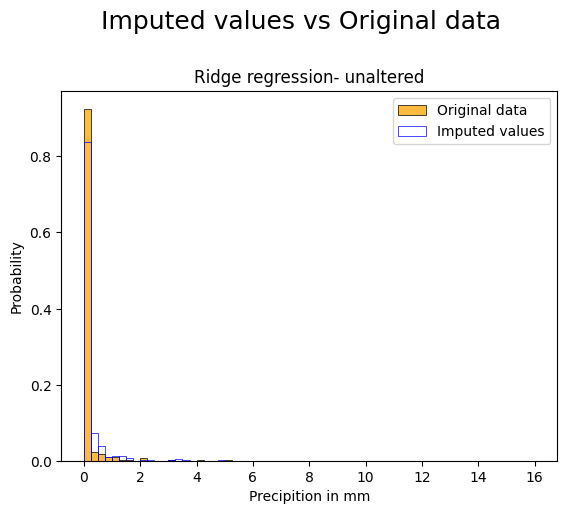

In [49]:
imputed_values = weather_data_imp.loc[index_of_na,['prcp']]
sns.histplot(weather_data['prcp'], binwidth=0.25, color='orange', stat='probability', label='Original data')
sns.histplot(imputed_values['prcp'], binwidth=0.25, color='blue', stat='probability',fill=False, label='Imputed values')
plt.suptitle('Imputed values vs Original data', y=1.05, fontsize=18)
plt.title('Ridge regression- unaltered')
plt.xlabel('Precipition in mm')
plt.legend()
plt.show()

As we can see from the histogram above, there are some values below zero, therefore we are going to transform the negative values to zero, and check how the values will be distributed doing this transofrmation. 

In [39]:
imputed_values['prcp'].lt(0).mean()

0.1437670609645132

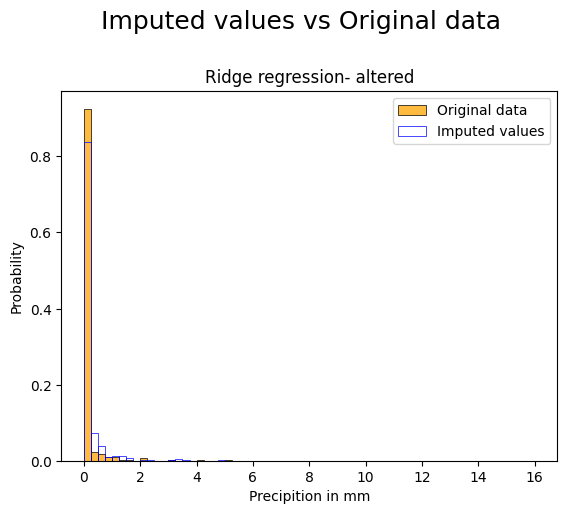

In [51]:
imputed_values = weather_data_imp.loc[index_of_na,['prcp']]
imputed_values[imputed_values.prcp.lt(0)] = 0

sns.histplot(weather_data['prcp'], binwidth=0.25, color='orange', stat='probability', label = 'Original data')
sns.histplot(imputed_values['prcp'], binwidth=0.25, color='blue', stat='probability', fill=False, label='Imputed values')
plt.suptitle('Imputed values vs Original data', y=1.05, fontsize=18)
plt.title('Ridge regression- altered')
plt.xlabel('Precipition in mm')
plt.legend()
plt.show()

Having tried Ridge regression, we are now going to try KNN with 3 neighbours. This choice comes from the fact that since our precipitation data is very imbalanced, with a very big percentage of zero values, a large number of neighbours could skew the imputation to smaller values, while a smaller number could result in a very high biased model. Other values were also tested and we felt that 3 was the optimal value.

In [41]:
# impute percipitation based on all other weather data except the date and wdir with KNN
unused_cols = ["date","wdir"]
imp = KNNImputer(n_neighbors=3)
transformed_data = imp.fit_transform(weather_data.drop(columns=unused_cols))

weather_data_imp = weather_data.copy()
weather_data_imp[weather_data_imp.columns.difference(unused_cols,sort=False)] = transformed_data

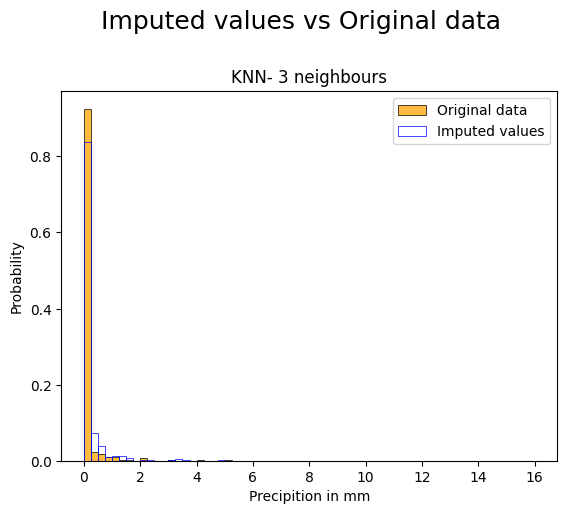

In [50]:
# TODO: remove lines around orange and add legend for all histopgrams

imputed_values = weather_data_imp.loc[index_of_na,['prcp']]
sns.histplot(weather_data['prcp'], binwidth=0.25, color='orange', stat='probability', label ='Original data')
sns.histplot(imputed_values['prcp'], binwidth=0.25, color='blue', stat='probability', fill=False, label='Imputed values')
plt.suptitle('Imputed values vs Original data', y=1.05, fontsize=18)
plt.title('KNN- 3 neighbours')
plt.xlabel('Precipition in mm')
plt.legend()
plt.show()

As we can see from the histograms above, the distribution of the imputed values when compared to the original data is a lot better for KNN then it is for Ridge regression, and therefore these are the imputed values we are gonna use going forward.

In [19]:
weather_data.prcp.value_counts().head(5)/len(weather_data.prcp)

0.0    0.779214
0.2    0.035936
0.1    0.022578
0.4    0.014305
0.6    0.009479
Name: prcp, dtype: float64

In [20]:
imputed_values.prcp.value_counts().head(5)/len(imputed_values.prcp)

0.000000    0.638763
0.066667    0.071884
0.033333    0.030937
0.133333    0.023658
0.333333    0.021838
Name: prcp, dtype: float64

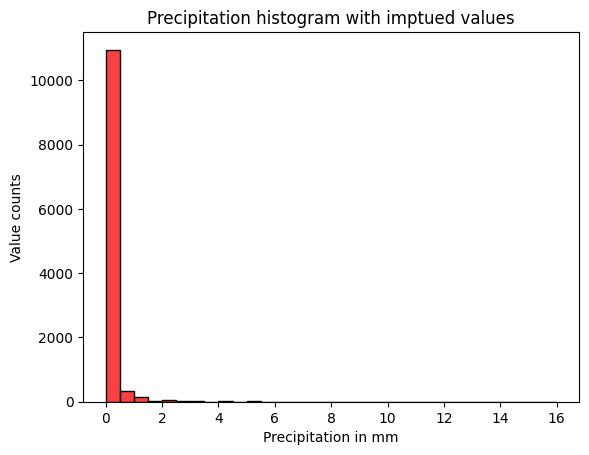

In [21]:
sns.histplot(weather_data_imp['prcp'], binwidth=0.5, color='red')
plt.xlabel('Precipitation in mm')
plt.ylabel('Value counts')
plt.title('Precipitation histogram with imputed values')
plt.show()

In [22]:
weather_data_imp['prcp'].describe()

count    11604.000000
mean         0.098638
std          0.456709
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: prcp, dtype: float64

## Saving weather data

In [24]:
# safe clean weather data without imputation
weather_data.to_csv("../data/weather_data.csv", index=False)

# safe weather data with imputed values
weather_data_imp.to_csv("../data/weather_data_imp.csv", index=False)